# TORN 2.0 Smart Vault simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as md
import pandas as pd
from datetime import datetime
import copy

In [2]:
contracts = {
    'cDAI' : '0x5d3a536e4d6dbd6114cc1ead35777bab948e3643',
    'wBTC': '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599',
    'wETH': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
}

Starting time of simulation

In [3]:
start_time = pd.to_datetime(datetime(2022, 2, 25), utc=True)

## Loading on-chain data

### Gas Price

In [115]:
GAS_Price = pd.read_csv('./GAS_Price(etherscan).csv')
#GAS_Price = GAS_Price.rename(columns={'day':'time', 'median_gas_price_gwei':'GAS price'})
GAS_Price = GAS_Price.rename(columns={'Date(UTC)':'time', 'Value (Wei)':'GAS price'})
GAS_Price = GAS_Price[['time', 'GAS price']]
GAS_Price['GAS price'] = GAS_Price['GAS price']/1e9
GAS_Price['time'] = pd.to_datetime(GAS_Price['time'], utc=True)
GAS_Price = GAS_Price[GAS_Price['time'] >= start_time]
GAS_Price = GAS_Price.sort_values(by='time').reset_index(drop=True)
GAS_Price.tail()

,time,GAS price
58,2022-04-24 00:00:00+00:00,35.954622
59,2022-04-25 00:00:00+00:00,57.799805
60,2022-04-26 00:00:00+00:00,50.687227
61,2022-04-27 00:00:00+00:00,57.662562
62,2022-04-28 00:00:00+00:00,57.139757


### BTC Price

In [116]:
wBTC_Price = pd.read_csv('./WBTC_Price.csv')
wBTC_Price = wBTC_Price.rename(columns={'snapped_at':'time', 'price':'wBTC price'})
wBTC_Price = wBTC_Price[['time', 'wBTC price']]
wBTC_Price['time'] = pd.to_datetime(wBTC_Price['time'])
wBTC_Price = wBTC_Price[wBTC_Price['time'] >= start_time]
wBTC_Price = wBTC_Price.sort_values(by='time').reset_index(drop=True)
wBTC_Price.tail()

,time,wBTC price
59,2022-04-25 00:00:00+00:00,39507.935405
60,2022-04-26 00:00:00+00:00,40434.614663
61,2022-04-27 00:00:00+00:00,38100.761831
62,2022-04-28 00:00:00+00:00,39207.130347
63,2022-04-29 00:00:00+00:00,39752.376591


### cDAI Price

In [117]:
cDAI_Price = pd.read_csv('./cDAI_Price.csv')
cDAI_Price = cDAI_Price.rename(columns={'snapped_at':'time', 'price':'cDAI price'})
cDAI_Price = cDAI_Price[['time', 'cDAI price']]
cDAI_Price['time'] = pd.to_datetime(cDAI_Price['time'])
cDAI_Price = cDAI_Price[cDAI_Price['time'] >= start_time]
cDAI_Price = cDAI_Price.sort_values(by='time').reset_index(drop=True)
cDAI_Price.tail()

,time,cDAI price
59,2022-04-25 00:00:00+00:00,0.021989
60,2022-04-26 00:00:00+00:00,0.021950
61,2022-04-27 00:00:00+00:00,0.021942
62,2022-04-28 00:00:00+00:00,0.021989
63,2022-04-29 00:00:00+00:00,0.022013


### TORN Price

In [118]:
TORN_Price = pd.read_csv('./TORN_Price.csv')
TORN_Price = TORN_Price.rename(columns={'snapped_at':'time', 'price':'TORN price'})
TORN_Price = TORN_Price[['time', 'TORN price']]
TORN_Price['time'] = pd.to_datetime(TORN_Price['time'])
TORN_Price = TORN_Price[TORN_Price['time'] >= start_time]
TORN_Price = TORN_Price.sort_values(by='time').reset_index(drop=True)
TORN_Price.tail()

,time,TORN price
59,2022-04-25 00:00:00+00:00,46.427514
60,2022-04-26 00:00:00+00:00,46.295592
61,2022-04-27 00:00:00+00:00,45.635695
62,2022-04-28 00:00:00+00:00,48.320925
63,2022-04-29 00:00:00+00:00,53.689114


### ETH Price

In [119]:
ETH_Price = pd.read_csv('./ETH_Price.csv')
ETH_Price = ETH_Price.rename(columns={'snapped_at':'time', 'price':'ETH price'})
ETH_Price = ETH_Price[['time', 'ETH price']]
ETH_Price['time'] = pd.to_datetime(ETH_Price['time'])
ETH_Price = ETH_Price[ETH_Price['time'] >= start_time]
ETH_Price = ETH_Price.sort_values(by='time').reset_index(drop=True)
ETH_Price.tail()

,time,ETH price
59,2022-04-25 00:00:00+00:00,2922.901865
60,2022-04-26 00:00:00+00:00,3008.336347
61,2022-04-27 00:00:00+00:00,2806.748836
62,2022-04-28 00:00:00+00:00,2889.592223
63,2022-04-29 00:00:00+00:00,2932.455084


### Relayer's transactions

All transactions have been prefiltered

In [120]:
relayers = pd.read_csv('./Relayers4.csv')
relayers = relayers[['block_time', 'tornado_pool', 'torn_fee', 'relayers_fee']]
relayers = relayers.rename(columns={'block_time':'time', 'tornado_pool':'pool', 'torn_fee':'torn fee', 'relayers_fee':'relayer fee'})
relayers['time'] = pd.to_datetime(relayers['time'])
relayers = relayers.sort_values(by='time', ignore_index=True).reset_index(drop=True)
relayers.tail()

,time,pool,torn fee,relayer fee
13345,2022-04-29 17:08:00+00:00,100 ETH,NaN,0.555000
13346,2022-04-29 17:17:00+00:00,10 ETH,NaN,0.092900
13347,2022-04-29 17:26:00+00:00,1 ETH,NaN,0.037819
13348,2022-04-29 17:30:00+00:00,10 ETH,NaN,0.079712
13349,2022-04-29 17:30:00+00:00,100 ETH,NaN,0.426000


### Tornado cash staking pool TVL

In [121]:
TVL = pd.read_csv('./TVL2.csv')
TVL = TVL[['evt_block_time', 'torn_balance']]
TVL = TVL.rename(columns={'evt_block_time':'time', 'torn_balance':'TVL'})
TVL = TVL.sort_values(by='time', ignore_index='True')
TVL['time'] = pd.to_datetime(TVL['time'], utc=True)
TVL

,time,TVL
0,2021-10-16 15:19:00+00:00,33064.417736
1,2021-10-16 15:54:00+00:00,33072.881506
2,2021-10-16 15:55:00+00:00,33064.417736
3,2021-10-19 01:58:00+00:00,32464.417736
4,2021-10-19 06:55:00+00:00,32399.025606
...,...,...
1170,2022-04-29 04:26:00+00:00,690796.012315
1171,2022-04-29 06:09:00+00:00,690893.882501
1172,2022-04-29 07:22:00+00:00,690907.003602
1173,2022-04-29 10:46:00+00:00,684737.918900


## Creating data frame

In [122]:
data = copy.deepcopy(relayers)
frames = [ETH_Price, TORN_Price, wBTC_Price, cDAI_Price, GAS_Price, TVL]
for f in frames:
    data = data.merge(right=f, on='time', how='outer')

data = data.sort_values(by='time', ignore_index=True).reset_index(drop=True)
# data['token'] = data['token'].str.replace('\\', '0')
# data['token'] = data['token'].fillna(value=0)
data['pool'] = data['pool'].fillna(value=0)
data['torn fee'] = data['torn fee'].fillna(value=0)
data['relayer fee'] = data['relayer fee'].fillna(value=0)
data = data.fillna(method='ffill')
data = data.fillna(method='bfill')

data = data[data['time'] >= start_time]
data = data.reset_index(drop=True)


data.head(5)

,time,pool,torn fee,relayer fee,ETH price,TORN price,wBTC price,cDAI price,GAS price,TVL
0,2022-02-25 00:00:00+00:00,0,0.000000,0.000000,2599.93357,31.272603,38317.380486,0.021908,68.352032,114669.203714
1,2022-02-25 00:09:00+00:00,100000 DAI,9.614443,461.017830,2599.93357,31.272603,38317.380486,0.021908,68.352032,114669.203714
2,2022-02-25 00:18:00+00:00,1 ETH,0.250023,0.043671,2599.93357,31.272603,38317.380486,0.021908,68.352032,114669.203714
3,2022-02-25 00:29:00+00:00,10 ETH,2.493217,0.079639,2599.93357,31.272603,38317.380486,0.021908,68.352032,114669.203714
4,2022-02-25 00:48:00+00:00,100 ETH,25.008733,0.385585,2599.93357,31.272603,38317.380486,0.021908,68.352032,114669.203714


## Creating empty frane

In [123]:
results = pd.DataFrame(copy.deepcopy(data['time']))
results['TORN staked'] = 0
results['TORN accumulated'] = 0
results['TORN accumulated by claim'] = 0
results['share'] = 0
results['TORN received'] = 0
results['GAS spent'] = 0
results['Token'] = 0
results['TORN claimed'] = 0
results['S per TORN'] = 0
results = results.sort_values(by='time', ignore_index=True).reset_index(drop=True)
results.head(1)

,time,TORN staked,TORN accumulated,TORN accumulated by claim,share,TORN received,GAS spent,Token,TORN claimed,S per TORN
0,2022-02-25 00:00:00+00:00,0,0,0,0,0,0,0,0,0


## Main simulation

In [86]:
def run(deposit, period_, results_, GAS = False):

    gas_claim = 100_000 * 1e-9 #gas for TORN claim operation
    gas_stake = 200_000 * 1e-9 #gas for TORN stake operatoin

    period = pd.Timedelta(hours=period_) #period (in hours) of claim
    results = copy.deepcopy(results_)
    results.loc[0, 'TORN staked'] = deposit
    last_claim = data['time'][0]
    last_claim_TORN = 0
    claimed = 0

    for i in range(1, len(results)):

        results.loc[i, 'TORN staked'] = results.loc[i-1, 'TORN staked']
        results.loc[i, 'TORN accumulated'] = results.loc[i-1, 'TORN accumulated']
        results.loc[i, 'share'] = results['TORN staked'][i]/data['TVL'][i]
        #results.loc[i, 'TORN accumulated by claim'] = results['TORN accumulated by claim'][i-1]

        if (data['torn fee'][i] != 0):

            received = results['share'][i] * data['torn fee'][i]
            results.loc[i, 'TORN received'] = received
            results.loc[i, 'TORN accumulated'] += received
            #results.loc[i, 'TORN accumulated by claim'] += claimed/data['TVL'][i] * data['torn fee'][i]


        td = data['time'][i] - last_claim
        
        if (td >= period):

            #claim_apt = results['TORN accumulated by claim'][i] / claimed if claimed != 0 else 0

            gas_cost_claim = gas_claim * data['ETH price'][i] * data['GAS price'][i] / data['TORN price'][i]
            claimed = results['TORN accumulated'][i] - gas_cost_claim * GAS
            results.loc[i, 'TORN claimed'] = claimed
            results.loc[i, 'TORN accumulated'] = 0
            #results.loc[i, 'TORN accumulated by claim'] = 0
            gas_cost_stake = gas_stake * data['ETH price'][i] * data['GAS price'][i] / data['TORN price'][i]
            results.loc[i, 'TORN staked'] += claimed - gas_cost_stake * GAS
            results.loc[i, 'GAS spent'] += gas_cost_claim + gas_cost_stake
            #results.loc[i, 'S per TORN'] = claim_apt

            last_claim = data['time'][i]

    gas_cost_claim = gas_claim * data['ETH price'][i] * data['GAS price'][i] / data['TORN price'][i]
    claimed = results['TORN accumulated'][i] - gas_cost_claim * GAS
    results.loc[i, 'TORN accumulated'] = 0
    gas_cost_stake = gas_stake * data['ETH price'][i] * data['GAS price'][i] / data['TORN price'][i]
    results.loc[i, 'TORN staked'] += claimed - gas_cost_stake * GAS
    results.loc[i, 'GAS spent'] += gas_cost_claim + gas_cost_stake

    # returns:
    # results
    # final TORN staked
    # gas spent in TORNs
    # gas spent in ETH

    return results, results.iloc[-1, :].loc['TORN staked'], results['GAS spent'].sum(), (results['GAS spent'] * data['TORN price'] / data['ETH price']).sum()
    

## Running simulations

In [14]:
# WARNING: RUNS approx. 20 minutes on Intel Core i7-11700H


d = 3 #period step
periods = np.array([d * i for i in range(1, int(24/d)*14)])

res500 = np.zeros(len(periods))
gases500 = np.zeros(len(periods))
stake500 = 500
for i, p in enumerate(periods):
    print('500:', p / max(periods) * 100)
    r500, t500, g500 = run(stake500, p, results)
    res500[i] = t500
    gases500[i] = g500


res10k = np.zeros(len(periods))
gases10k = np.zeros(len(periods))
stake10k = 10000
for i, p in enumerate(periods):
    print('10k:', p / max(periods) * 100)
    r10, t10, g10 = run(stake10k, p, results)
    res10k[i] = t10
    gases10k[i] = g10

res50k = np.zeros(len(periods))
gases50k = np.zeros(len(periods))
stake50k = 50000
for i, p in enumerate(periods):
    print('50k:', p / max(periods) * 100)
    r50, t50, g50 = run(stake50k, p, results)
    res50k[i] = t50
    gases50k[i] = g50

500: 0.9009009009009009
500: 1.8018018018018018
500: 2.7027027027027026
500: 3.6036036036036037
500: 4.504504504504505
500: 5.405405405405405
500: 6.306306306306306
500: 7.207207207207207
500: 8.108108108108109
500: 9.00900900900901
500: 9.90990990990991
500: 10.81081081081081
500: 11.711711711711711
500: 12.612612612612612
500: 13.513513513513514
500: 14.414414414414415
500: 15.315315315315313
500: 16.216216216216218
500: 17.117117117117118
500: 18.01801801801802
500: 18.91891891891892
500: 19.81981981981982
500: 20.72072072072072
500: 21.62162162162162
500: 22.52252252252252
500: 23.423423423423422
500: 24.324324324324326
500: 25.225225225225223
500: 26.126126126126124
500: 27.027027027027028
500: 27.927927927927925
500: 28.82882882882883
500: 29.72972972972973
500: 30.630630630630627
500: 31.53153153153153
500: 32.432432432432435
500: 33.33333333333333
500: 34.234234234234236
500: 35.13513513513514
500: 36.03603603603604
500: 36.93693693693694
500: 37.83783783783784
500: 38.73873873

In [124]:
# Runs approx. 4 minuts

res200k = np.zeros(len(periods))
gases200k = np.zeros(len(periods))
gases_torn200k = np.zeros(len(periods))
stake200k = 200e3
for i, p in enumerate(periods):
    print('200k:', p / max(periods) * 100)
    r200, t200, gt200, g200 = run(stake200k, p, results)
    res200k[i] = t200
    gases_torn200k[i] = gt200
    gases200k[i] = g200

200k: 0.9009009009009009
200k: 1.8018018018018018
200k: 2.7027027027027026
200k: 3.6036036036036037
200k: 4.504504504504505
200k: 5.405405405405405
200k: 6.306306306306306
200k: 7.207207207207207
200k: 8.108108108108109
200k: 9.00900900900901
200k: 9.90990990990991
200k: 10.81081081081081
200k: 11.711711711711711
200k: 12.612612612612612
200k: 13.513513513513514
200k: 14.414414414414415
200k: 15.315315315315313
200k: 16.216216216216218
200k: 17.117117117117118
200k: 18.01801801801802
200k: 18.91891891891892
200k: 19.81981981981982
200k: 20.72072072072072
200k: 21.62162162162162
200k: 22.52252252252252
200k: 23.423423423423422
200k: 24.324324324324326
200k: 25.225225225225223
200k: 26.126126126126124
200k: 27.027027027027028
200k: 27.927927927927925
200k: 28.82882882882883
200k: 29.72972972972973
200k: 30.630630630630627
200k: 31.53153153153153
200k: 32.432432432432435
200k: 33.33333333333333
200k: 34.234234234234236
200k: 35.13513513513514
200k: 36.03603603603604
200k: 36.9369369369369

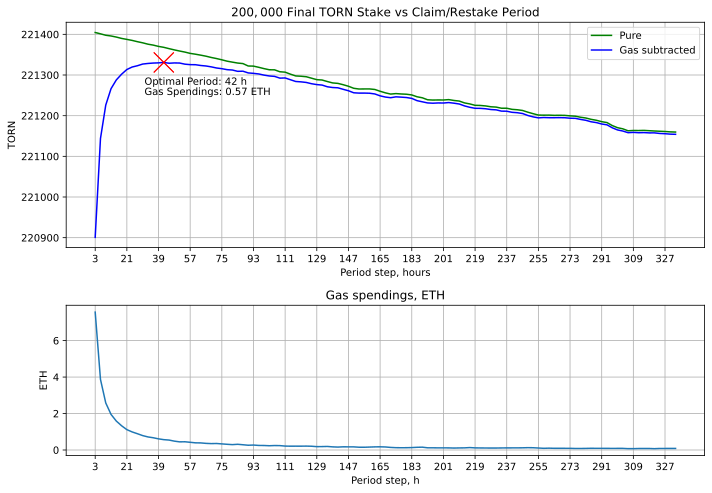

In [138]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]})

ax1.plot(periods, res200k, color='green', label='Pure')
ax1.plot(periods, res200k - gases_torn200k, color='blue', label='Gas subtracted')
ax1.set_title('${:,.0f}$ Final TORN Stake vs Claim/Restake Period'.format(stake200k))
ax1.set_xlabel('Period step, hours')
ax1.set_xticks(periods[::6])
ax1.set_ylabel('TORN')
ax1.grid()
ax1.legend()


y = res200k - gases_torn200k
idx = np.argmax(y)
x1 = periods[idx]
y1 = y[idx]

ax1.plot([x1, x1], [y1, y1], lw=0, marker='x', markersize=20, color='red')
ax1.text(x=x1-11, y=y1 - 55, s='Optimal Period: {:,.0f} h'.format(x1))
ax1.text(x=x1-11, y=y1 - 80, s='Gas Spendings: {:,.2f} ETH'.format(gases200k[idx]))


ax2.plot(periods, gases200k)
ax2.set_title('Gas spendings, ETH')
ax2.set_xlabel('Period step, h')
ax2.set_ylabel('ETH')
ax2.set_xticks(periods[::6])
ax2.grid()

fig.set_size_inches(10, 7)
plt.tight_layout()
#ax1.set_ylim((510, 530))

In [149]:
(res200k[idx] - stake200k) / stake200k * (year / delta)

0.6119146551180905

In [156]:
(221400 - 200000)/200000 * year / delta

0.6128277214776071

In [148]:
delta = results['time'].iloc[-1] - results['time'].iloc[0]
delta
year = pd.Timedelta('365d')
year

year / delta

5.727361882968291

In [139]:
stake = 1000

ps = np.array([3, 24, 72])
torns = np.zeros(ps.shape, dtype=object)

for i, p_ in enumerate(ps):
    torns[i]  = run(stake, p_, results)

In [163]:
pps = 10000
pptorns = run(1000, pps, results)

In [164]:
res = pptorns[0]
(res['TORN staked'].iloc[-1] - res['GAS spent'].iloc[-1] - 1000) / res['TORN staked'].iloc[-1] * (year / delta)

0.5238236251623708

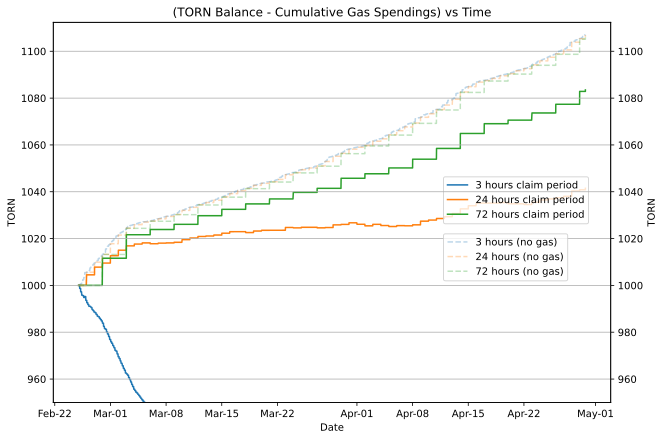

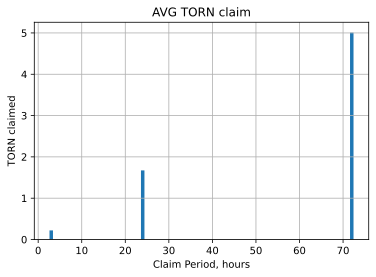

In [136]:
%config InlineBackend.figure_format='svg'

fig, ax = plt.subplots()
ax1 = ax.twinx()

for i, t in enumerate(torns):
    ax.plot(t['time'], t['TORN staked'] - t['GAS spent'].cumsum(), label='{} hours claim period'.format(ps[i]))
    ax1.plot(t['time'], t['TORN staked'], alpha=0.3, linestyle='--', label='{} hours (no gas)'.format(ps[i]))

bot = min(ax.get_ylim())
top = max(ax1.get_ylim())

ax.set_ylim(bottom=950, top=top)
ax1.set_ylim(bottom=950, top=top)

ax.set_ylabel('TORN')
ax.set_xlabel('Date')

plt.title('(TORN Balance - Cumulative Gas Spendings) vs Time')
plt.xlabel('Date')
plt.ylabel('TORN')
plt.grid()
plt.gca().xaxis.set_major_formatter(formatter=md.DateFormatter('%b-%d'))

legx = 0.7#pd.to_datetime(datetime(2022, 3, 21))
legy = 0.47

ax.legend(loc=(legx, legy))
ax1.legend(loc=(legx, legy-0.15))

fig.set_size_inches(10, 7)


fig, ax = plt.subplots()

ax.bar(ps, [t[t['TORN claimed'] != 0]['TORN claimed'].mean() for t in torns])
ax.set_title('AVG TORN claim')
ax.set_ylabel('TORN claimed')
ax.set_xlabel('Claim Period, hours')
ax.grid()